# First- and second-level modeling
Natalia Vélez, April 2018

This script does first- and second-level modeling, using outputs from fmriprep. Our workflow is based on [this script](https://github.com/poldrack/fmri-analysis-vm/blob/master/analysis/postFMRIPREPmodelling) from the Poldrack Lab repository.

Load libraries:

In [1]:
from IPython.display import Image # Debug

import os  # system functions
import pandas as pd
import glob
import numpy as np
import json
from os.path import join as opj
import nipype.interfaces.io as nio  # Data i/o
import nipype.interfaces.fsl as fsl  # fsl
from nipype.interfaces import utility as niu  # Utilities
import nipype.pipeline.engine as pe  # pypeline engine
import nipype.algorithms.modelgen as modelgen  # model generation
import nipype.algorithms.rapidart as ra  # artifact detection

from bids.grabbids import BIDSLayout

from nipype.workflows.fmri.fsl import (create_featreg_preproc,
                                       create_modelfit_workflow,
                                       create_fixed_effects_flow)

from nipype import config
config.enable_debug_mode()

/opt/conda/envs/neuro/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Project directory and function inputs:

In [2]:
# For testing (COMMENT)
project = 'SwiSt'
subject = 'sub-04'
task = 'tomloc'
model = 'localizer'
n_runs = 2
runs = list(range(1, n_runs+1))

# Location of project
scratch_dir = os.environ['SCRATCH']
project_dir = opj(scratch_dir, project, 'BIDS_data')
derivatives_dir = opj(project_dir, 'derivatives')
working_dir = opj(scratch_dir, 'swist_cache', 'l1_model', 'task-%s_model-%s_%s' %(task, model, subject))

# DEBUG
print(project_dir)
print(subject)
print(runs)

/scratch/users/nvelez/SwiSt/BIDS_data
sub-04
[1, 2]


Task repetition time:

In [3]:
task_info_file = opj(project_dir, 'task-%s_bold.json' % task)

# Load task info
with open(task_info_file, 'r') as f:
    task_info = json.load(f)

# Get TR from task info
TR = task_info['RepetitionTime']
print('TR: %.02f' % TR) # DEBUG

TR: 2.00


## Model fitting workflow

**IdentityInterface:** Iterate over subjects and runs

In [4]:
inputnode = pe.Node(niu.IdentityInterface(fields=['project', 'subject_id', 'task', 'model', 'run'],
                                         mandatory_inputs=True),
                   'inputnode')
inputnode.iterables = [('run', runs)]
inputnode.inputs.project = project
inputnode.inputs.subject_id = subject
inputnode.inputs.task = task
inputnode.inputs.model = model

**DataGrabber:** Select files

In [5]:
# Templates for DataGrabber
func_template = 'fmriprep/%s/func/*task-%s_run-%02d_bold_space-MNI152NLin2009cAsym_preproc.nii.gz'
anat_template = 'fmriprep/%s/anat/*T1w_space-MNI152NLin2009cAsym_preproc.nii.gz'
mask_template = 'fmriprep/%s/func/*task-%s_run-%02d_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz'
confounds_template = 'fmriprep/%s/func/*task-%s_run-%02d_bold_confounds.tsv'
model_template = 'l1_model_specification/task-%s_model-%s/%s*run-%02d.json'

In [6]:
datasource = pe.Node(nio.DataGrabber(infields=['subject_id',
                                               'task',
                                               'model',
                                               'run'],
                                    outfields=['struct',
                                               'func',
                                               'mask',
                                               'confounds_file',
                                               'model_file']),
                    'datasource')

datasource.inputs.base_directory = derivatives_dir
datasource.inputs.template = '*'
datasource.inputs.sort_filelist = True
datasource.inputs.field_template = dict(struct=anat_template,
                                       func=func_template,
                                       mask=mask_template,
                                       confounds_file=confounds_template,
                                       model_file=model_template)
datasource.inputs.template_args = dict(struct=[['subject_id']],
                                      func=[['subject_id', 'task', 'run']],
                                      mask=[['subject_id', 'task', 'run']],
                                      confounds_file=[['subject_id', 'task', 'run']],
                                      model_file=[['task', 'model', 'subject_id', 'run']])

**ModelGrabber:** Grab model specification info (util)

In [7]:
def ModelGrabber(project, model_file, confounds_file):
    from os import environ
    import pandas as pd
    from nipype.interfaces.base import Bunch
    from os.path import join as opj
    from json import load as loadjson
    
    # Project dir
    project_dir = opj(environ['SCRATCH'], project, 'BIDS_data')
    
    ### Model specification ###
    with open(model_file, 'rb') as model_handle:
        data = loadjson(model_handle)
        
    model = data['model']
    contrasts = data['contrasts']
    
    ### Confounds ###
    confound_names = ['X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ',
                      'FramewiseDisplacement',
                      'aCompCor00', 'aCompCor01', 'aCompCor02',
                      'aCompCor03', 'aCompCor04', 'aCompCor05']
    all_confounds = pd.read_csv(confounds_file, sep = '\t', index_col=None)
    confounds_df = all_confounds[confound_names]
    confounds_df.FramewiseDisplacement = confounds_df.FramewiseDisplacement.fillna(0)
    confounds_dict = confounds_df.to_dict('list')
    
    # Convert confounds to dictionary
    confounds = {'regressor_names': confound_names,
                'regressors': [confounds_dict[name] for name in confound_names]}
    
    ### Putting everything together ###
    modelspec_dict = model.copy()
    modelspec_dict.update(confounds)
    
    modelspec = Bunch(**modelspec_dict)
    
    return modelspec, contrasts


# Make node
model_grabber = pe.Node(niu.Function(input_names=['project', 'model_file', 'confounds_file'],
                                     output_names=['modelspec', 'contrasts'],
                                     function=ModelGrabber),
                        'model_grabber')

**ModelSpec**: Model specification

In [8]:
modelspec = pe.Node(modelgen.SpecifyModel(),
                   'modelspec')
modelspec.inputs.time_repetition = TR
modelspec.inputs.input_units = 'secs'
modelspec.inputs.high_pass_filter_cutoff = 128.0

**level1design:** Generate FEAT-specific files

In [9]:
l1design = pe.Node(fsl.model.Level1Design(),
                  'l1design')
l1design.inputs.bases = {'dgamma':{'derivs': True}}
l1design.inputs.model_serial_correlations = True
l1design.inputs.interscan_interval = TR

**FEATModel:** Prepare design file for first-level model

In [10]:
featmodel = pe.Node(fsl.model.FEATModel(),
                   'featmodel')

**ApplyMask:** Prepare brainmask for modeling

In [11]:
mask = pe.Node(fsl.maths.ApplyMask(),
              'mask')

**FILM:** Run-specific model

In [12]:
filmgls = pe.Node(fsl.FILMGLS(),
                  'filmgls')
filmgls.inputs.autocorr_noestimate = True

**DataSink:** Specify outputs of first-level modeling workflow

In [16]:
datasink = pe.Node(nio.DataSink(),
                  'datasink')
datasink.inputs.base_directory = opj(derivatives_dir, 'run_model', subject)
datasink.inputs.substitutions = [('_run_', 'run-0')]
#datasink.inputs.parametrization = False

**MergeModel**: Merge model outputs (for first-level model)

In [26]:
mergesource = pe.Node(niu.IdentityInterface(fields = ['mask', 'dof_file', 'copes', 'varcopes']),
                     'mergesource')
mergemodel = pe.JoinNode(niu.IdentityInterface(fields = ['mask', 'dof_file', 'copes', 'varcopes']),
                        joinsource='mergesource',
                        name='mergemodel')

**fixedeffects:** Fixed effects workflow

In [27]:
fixedfx = create_fixed_effects_flow()

Helper functions:

In [43]:
def sort_copes(files):
    numelements = len(files)
    outfiles = []
    for i in range(numelements):
        outfiles.insert(i, [])
        for j, elements in enumerate(files):
            outfiles[i].append(elements[i])
    return outfiles


def num_copes(files):
    return len(files)


pickfirst = lambda x: x[0]

**l1_workflow:** Build and run first-level modeling workflow

In [44]:
l1_workflow = pe.Workflow('l1', base_dir = working_dir)

l1_workflow.connect([(inputnode, datasource, [('subject_id', 'subject_id'),
                                                 ('task', 'task'),
                                                 ('model', 'model'),
                                                 ('run', 'run')]),
                     (inputnode, model_grabber, [('project', 'project')]),
                     (datasource, model_grabber, [('model_file', 'model_file'),
                                                 ('confounds_file', 'confounds_file')]),
                     (datasource, modelspec, [('func', 'functional_runs')]),
                     (model_grabber, modelspec, [('modelspec', 'subject_info')]),
                     (model_grabber, l1design, [('contrasts', 'contrasts')]),
                     (modelspec, l1design, [('session_info', 'session_info')]),
                     (l1design, featmodel, [('fsf_files', 'fsf_file'),
                                            ('ev_files', 'ev_files')]),
                     (datasource, mask, [('mask', 'mask_file'),
                                         ('func', 'in_file')]),
                     (mask, filmgls, [('out_file', 'in_file')]),
                     (featmodel, filmgls, [('design_file', 'design_file'),
                                          ('con_file', 'tcon_file'),
                                          ('fcon_file', 'fcon_file')]),
                     (mask, mergesource, [('out_file', 'mask')]),
                     (filmgls, mergesource, [('copes', 'copes'),
                                            ('varcopes', 'varcopes'),
                                            ('dof_file', 'dof_file')]),
                     (mergesource, mergemodel, [('mask', 'mask'),
                                                ('copes', 'copes'),
                                                ('varcopes', 'varcopes'),
                                                ('dof_file', 'dof_file')]),
                     (mergemodel, fixedfx, [(('mask', pickfirst), 'flameo.mask_file'),
                                            (('copes', sort_copes), 'inputspec.copes'),
                                            ('dof_file', 'inputspec.dof_files'),
                                            (('varcopes', sort_copes), 'inputspec.varcopes'),
                                            (('copes', num_copes), 'l2model.num_copes')]),
                     (featmodel, datasink, [('design_file', 'design.@design_matrix')]),
                     (mask, datasink, [('out_file', 'input.@masked_functional')]),
                     (filmgls, datasink, [('zstats', 'film.@zstats'),
                                         ('copes', 'film.@copes'),
                                         ('varcopes', 'film.@varcopes'),
                                         ('param_estimates', 'film.@param'),
                                         ('dof_file', 'film.@dof')])
                    ])

In [45]:
l1_workflow.run()

180521-02:43:59,268 workflow INFO:
	 Workflow l1 settings: ['check', 'execution', 'logging', 'monitoring']
180521-02:43:59,325 workflow INFO:
	 Running serially.
180521-02:43:59,329 workflow INFO:
	 [Node] Setting-up "l1.datasource" in "/scratch/users/nvelez/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_2/datasource".
180521-02:43:59,368 workflow INFO:
	 [Node] Running "datasource" ("nipype.interfaces.io.DataGrabber")
180521-02:43:59,396 workflow INFO:
	 [Node] Finished "l1.datasource".
180521-02:43:59,400 workflow INFO:
	 [Node] Setting-up "l1.mask" in "/scratch/users/nvelez/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_2/mask".
180521-02:43:59,412 workflow INFO:
	 [Node] Cached "l1.mask" - collecting precomputed outputs
180521-02:43:59,415 workflow INFO:
	 [Node] "l1.mask" found cached.
180521-02:43:59,419 workflow INFO:
	 [Node] Setting-up "l1.model_grabber" in "/scratch/users/nvelez/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/_run_

ValueError: Input in_files was not set but it is listed in iterfields.

## QA (Debug Only)

Plot workflow:

180521-02:42:48,976 workflow INFO:
	 Generated workflow graph: /scratch/users/nvelez/swist_cache/l1_model/task-tomloc_model-localizer_sub-04/l1/graph.png (graph2use=colored, simple_form=True).


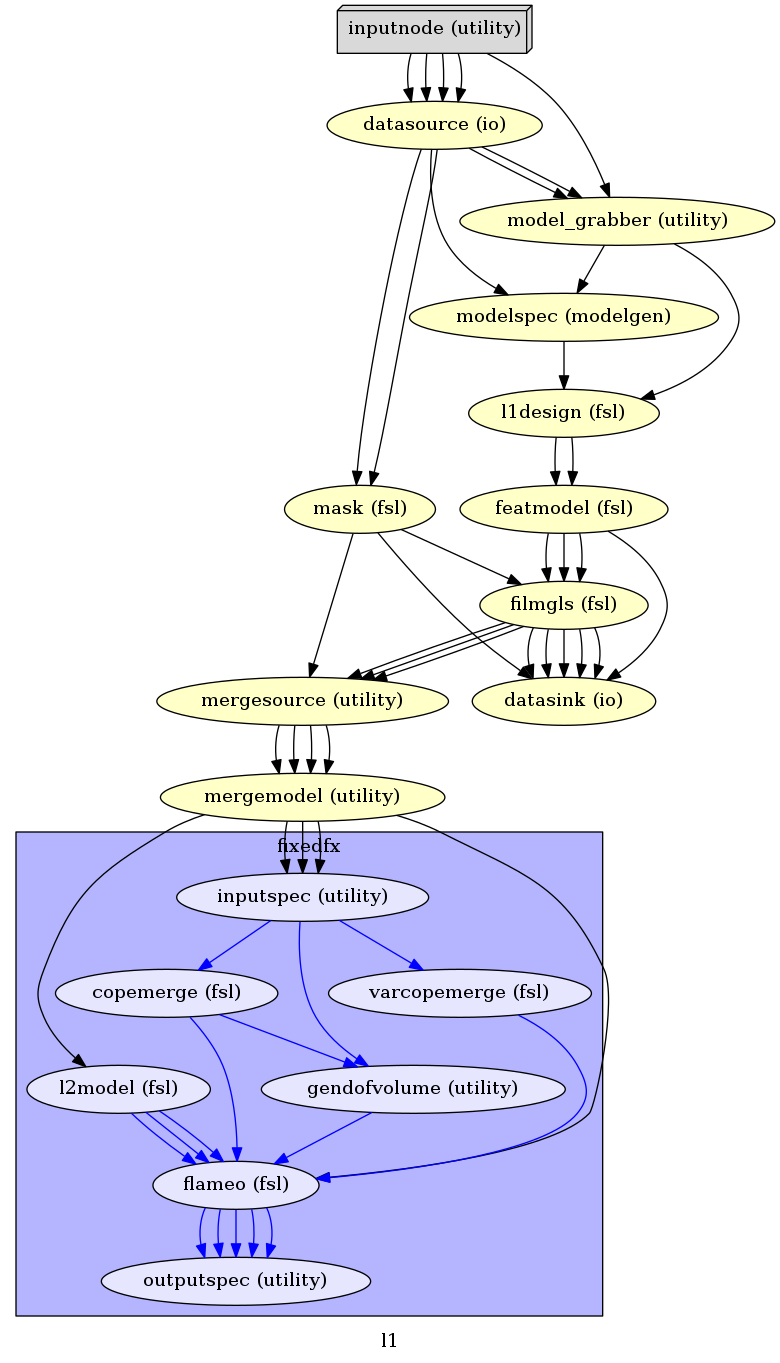

In [39]:
l1_workflow.write_graph(graph2use='colored', format='png', simple_form=True)
Image(filename=opj(l1_workflow.base_dir, 'l1', 'graph.png'))